Shape des données : (2042, 64, 64)
Type de données : FREQ


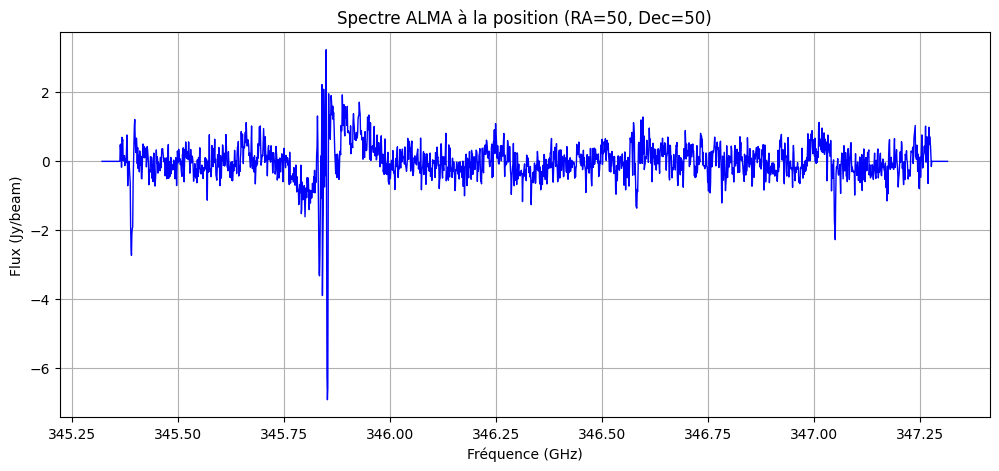

In [245]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt


file_path = 'spectre3.fits'


data = fits.getdata(file_path)[0]
header = fits.getheader(file_path)


print("Shape des données :", data.shape)
print("Type de données :", header['CTYPE3']) 

n_channels = header['NAXIS3']  
freq_start = header['CRVAL3']  
freq_step = header['CDELT3']  

freq = (freq_start + freq_step * np.arange(n_channels)) / 1e9  


spectrum = data[:, 50, 50]  


plt.figure(figsize=(12, 5))
plt.plot(freq, spectrum, 'b-', linewidth=1)
plt.xlabel('Fréquence (GHz)')
plt.ylabel('Flux (Jy/beam)')
plt.title(f'Spectre ALMA à la position (RA={50}, Dec={50})')
plt.grid()
plt.show()

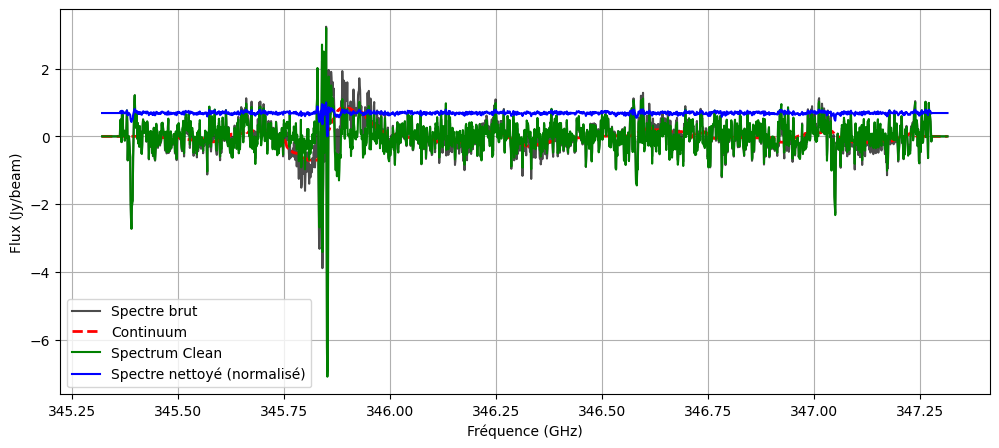

In [246]:
from scipy.ndimage import median_filter

spectrum = np.asarray(spectrum, dtype=np.float64) 

continuum = median_filter(spectrum, size=101) 

spectrum_clean = spectrum - continuum

# Normalisation entre 0 et 1
spectrum_norm = (spectrum_clean - np.min(spectrum_clean)) / (np.max(spectrum_clean) - np.min(spectrum_clean))



plt.figure(figsize=(12, 5))
plt.plot(freq, spectrum, 'k-', label='Spectre brut', alpha=0.7)
plt.plot(freq, continuum, 'r--', label='Continuum', linewidth=2)
plt.plot(freq, spectrum_clean, 'g-', label='Spectrum Clean')
plt.plot(freq, spectrum_norm, 'b-', label='Spectre nettoyé (normalisé)')
plt.xlabel('Fréquence (GHz)')
plt.ylabel('Flux (Jy/beam)')
plt.legend()
plt.grid()
plt.show()

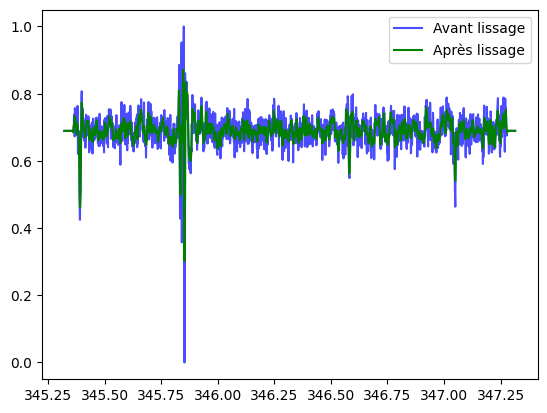

In [247]:
from scipy.signal import savgol_filter

spectrum_smoothed = savgol_filter(spectrum_norm, window_length=11, polyorder=3)  # Ajuster la fenêtre

plt.plot(freq, spectrum_norm, 'b-', label='Avant lissage', alpha=0.7)
plt.plot(freq, spectrum_smoothed, 'g-', label='Après lissage')
plt.legend()
plt.show()

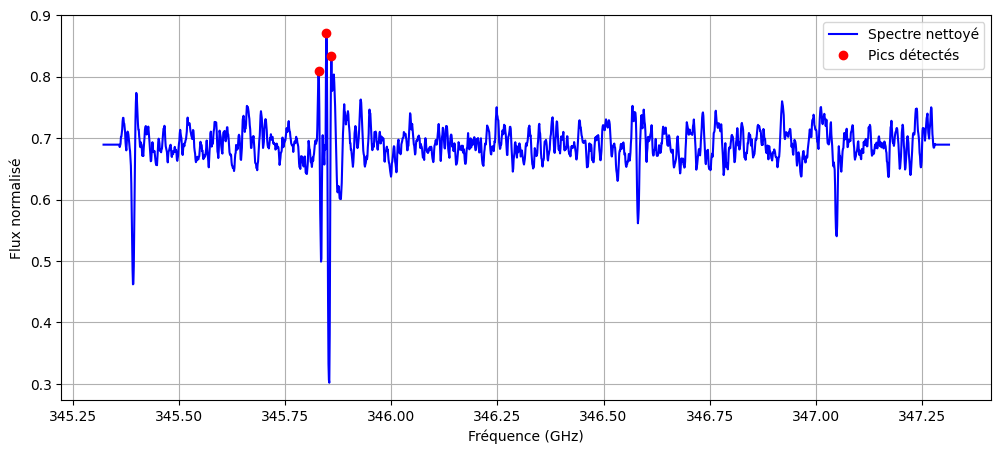

In [248]:
from scipy.signal import find_peaks


peaks, propertiers = find_peaks(spectrum_smoothed, height=0.8, distance=10 )


plt.figure(figsize=(12, 5))
plt.plot(freq, spectrum_smoothed, 'b-', label='Spectre nettoyé')
plt.plot(freq[peaks], spectrum_smoothed[peaks], 'ro', label='Pics détectés')
plt.xlabel('Fréquence (GHz)')
plt.ylabel('Flux normalisé')
plt.legend()
plt.grid()
plt.show()

/tmp/cache-flgrenier/ipykernel_3271520/1964703341.py:17: RuntimeWarning: overflow encountered in power
  filtered_int = 10 ** data[:,1]
/tmp/cache-flgrenier/ipykernel_3271520/1964703341.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


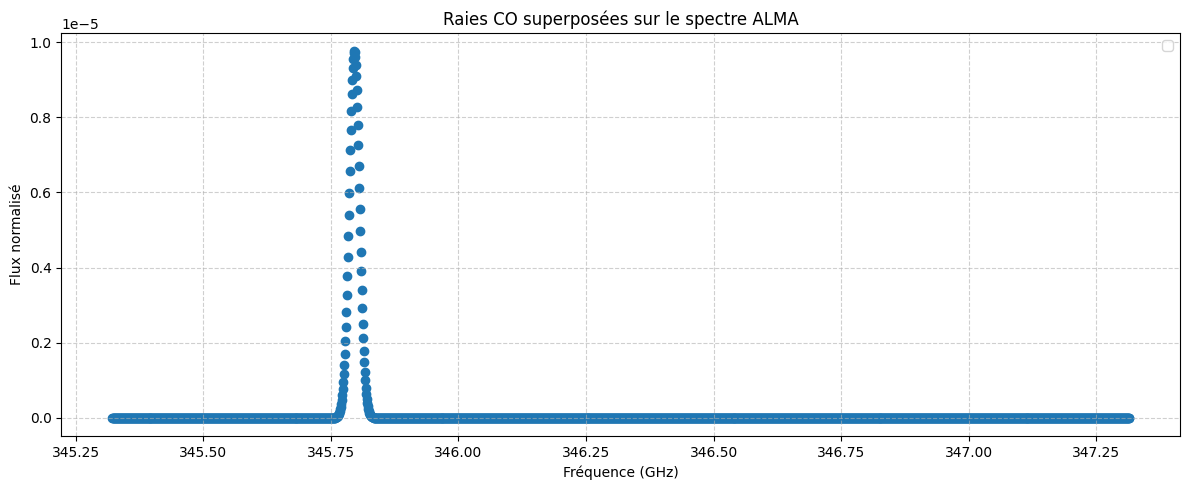

In [249]:

from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

data = []
with open("COv2.cat", "r") as f:
    for line in f:
        if not line.startswith(('!', '*')):
            parts = line.split()
            freq_mhz = float(parts[0])
            log_intensity = float(parts[2])
            energy_lower = float(parts[4])
            data.append([freq_mhz, log_intensity, energy_lower])

data = np.array(data)
frequencies_ghz = data[:, 0] / 1e3  # MHz -> GHz
filtered_int = 10 ** data[:,1]

mask = (frequencies_ghz >= freq.min()) & (frequencies_ghz <= freq.max())
filtered_freq = frequencies_ghz[mask]



def create_reference_spectrum(freq_range, line_freqs, line_ints, sigma=0.01):

    spectrum = np.zeros_like(freq_range)
    for f, i in zip(line_freqs, line_ints):
        spectrum += i * np.exp(-(freq_range - f)**2 / (2 * sigma**2))
    return spectrum

# Créez un spectre de référence CO
freq_range = np.linspace(freq.min(), freq.max(), len(freq))
ref_spectrum = create_reference_spectrum(freq_range, filtered_freq, filtered_int)


plt.figure(figsize=(12, 5))



# Points rouges aux fréquences des raies CO
plt.scatter(freq_range, ref_spectrum)

plt.xlabel("Fréquence (GHz)")
plt.ylabel("Flux normalisé")
plt.title("Raies CO superposées sur le spectre ALMA")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [250]:
from dtaidistance import dtw
# Normalisation des spectres
obs_spectrum_norm = (spectrum_smoothed - np.min(spectrum_smoothed)) / (np.max(spectrum_smoothed) - np.min(spectrum_smoothed))
ref_spectrum_norm = (ref_spectrum - np.min(ref_spectrum)) / (np.max(ref_spectrum) - np.min(ref_spectrum))

# Calcul de la distance DTW
distance, paths = dtw.warping_paths(obs_spectrum_norm, ref_spectrum_norm)
best_path = dtw.best_path(paths)

# Convertir le chemin en indices alignés
obs_indices = [p[0] for p in best_path]
ref_indices = [p[1] for p in best_path]

# Fréquences alignées
aligned_freq_obs = freq_range[obs_indices]
aligned_freq_ref = filtered_freq[np.searchsorted(filtered_freq, freq_range[ref_indices])]

IndexError: index 1 is out of bounds for axis 0 with size 1

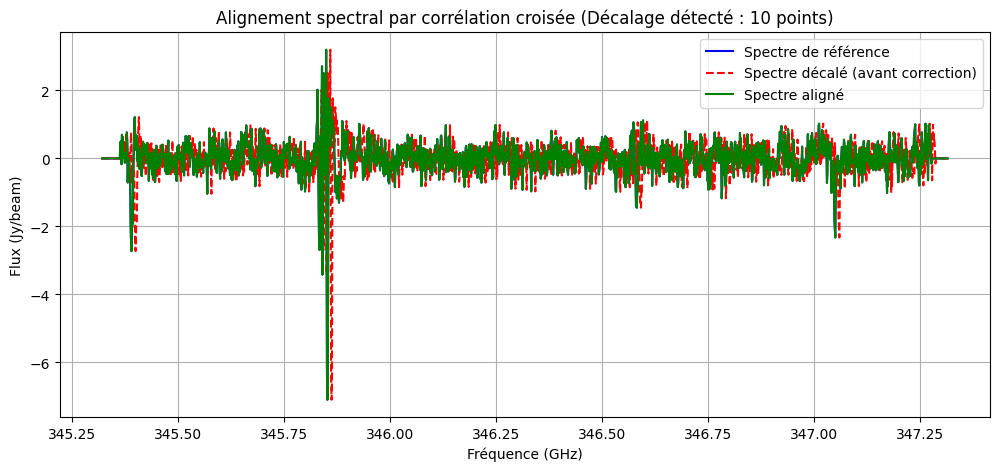

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def cross_correlation_alignment(ref_spectrum, target_spectrum):
    
    correlation = np.correlate(target_spectrum - np.mean(target_spectrum),
                               ref_spectrum - np.mean(ref_spectrum), mode='full')
    
    
    shift = np.argmax(correlation) - (len(target_spectrum) - 1)
    
    
    aligned_spectrum = np.roll(target_spectrum, -shift)

    return aligned_spectrum, shift


# Simuler un autre spectre légèrement décalé pour tester
spectrum_shifted = np.roll(spectrum_clean, 10) 

aligned_spectrum, found_shift = cross_correlation_alignment(spectrum_clean, spectrum_shifted)

plt.figure(figsize=(12, 5))
plt.plot(freq, spectrum_clean, 'b-', label='Spectre de référence')
plt.plot(freq, spectrum_shifted, 'r--', label='Spectre décalé (avant correction)')
plt.plot(freq, aligned_spectrum, 'g-', label='Spectre aligné')
plt.xlabel('Fréquence (GHz)')
plt.ylabel('Flux (Jy/beam)')
plt.legend()
plt.grid()
plt.title(f"Alignement spectral par corrélation croisée (Décalage détecté : {found_shift} points)")
plt.show()
